In [1]:
#import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from collections import defaultdict
import pandas as pd

In [2]:
np.random.seed(7)

In [3]:
def get_triplets(lst):
    """
    '1234' -> ['123','234']
    """
    res = []
    for i in range(len(lst) - 2):
        res.append(lst[i]+lst[i + 1]+lst[i + 2])
    return res


def get_dinucleotides(lst):
    """
    '123' -> ['12', '23']
    """
    res = []
    for i in range(len(lst) - 1):
        res.append(lst[i]+lst[i + 1])
    return res

In [4]:
#True: Last bases of Alus
with open('/Users/alexandershein/Code/study/CourseProject/transposones/sequences/L1_last_50_bs_2.txt','r') as f:
    dt = np.unique(list(map(lambda x: x.strip(),f.readlines())))

In [5]:
#False: Random genome sequences
with open('/Users/alexandershein/Code/study/CourseProject/transposones/sequences/random_nt_seq.txt','r') as f:
    df = np.unique(list(map(lambda x: x.strip(),f.readlines())))


In [6]:
len(dt), len(df)

(4248, 19999)

In [7]:
# Balancing alternative
# d = df if len(df) > len(dt) else dt
p = len(df)/len(dt); m = min(p,1/p)
np.random.seed(7)
df = np.random.choice(df,round(len(df)*m), replace=False)
dt = np.random.choice(dt, len(dt), replace=False)

In [8]:
len(dt), len(df)

(4248, 4248)

In [9]:
alph = ['A','C','G','T']
alph_dict = {'A':1,'C':2,'G':3,'T':4}
pairs = [''.join(i) for i in product(alph, repeat=2)]
triplets = [''.join(i) for i in product(alph, repeat=3)]

In [10]:
x_t, y_t = [], []
for line in dt:
    row = {}
    for di_n in get_dinucleotides(line)+get_triplets(line):
        row[di_n]=row.get(di_n,0)+1
    for pos in range(len(line)):
        row[f'P{pos}']=alph_dict[line[pos]]
    y_t.append(1)
    x_t.append(row)

In [11]:
x_f, y_f = [], []
for line in df:
    row = {}
    for di_n in get_dinucleotides(line)+get_triplets(line):
        row[di_n]=row.get(di_n,0)+1
    for pos in range(len(line)):
        row[f'P{pos}']=alph_dict[line[pos]]
    y_f.append(0)
    x_f.append(row)

In [12]:
x_all = pd.DataFrame(x_t + x_f).fillna(0)
y_all = np.array(y_t + y_f)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x_all, y_all, random_state=7, test_size=0.3)

In [14]:
np.mean(y_train), np.mean(y_test)

(0.4978980998822936, 0.5049038838760298)

In [15]:
#tr = xgboost.XGBClassifier(max_depth=5,n_estimators=100,random_state=7)
#params = {"max_depth":[5,8,11,15,20], "n_estimators":[100,1000,2000]}

In [16]:
tr = RandomForestClassifier(max_depth=5,n_estimators=100,random_state=7)
params = {"max_depth":[5,8,11,15,20], "n_estimators":[100,1000,2000]}

In [17]:
gr = GridSearchCV(tr,param_grid=params,n_jobs=6,cv=5,)

In [18]:
gr.fit(x_train,y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=7, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=6,
       param_grid={'max_depth': [5, 8, 11, 15, 20], 'n_estimators': [100, 1000, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [19]:
gr.best_score_, gr.best_params_

(0.9857070791995964, {'max_depth': 11, 'n_estimators': 1000})

In [20]:
y_pred = gr.best_estimator_.predict(x_test)

In [21]:
roc_auc_score(y_test,y_pred)

0.9836368069331619

In [22]:
fpr, tpr, _ = roc_curve(y_test,gr.best_estimator_.predict_proba(x_test)[:,1])

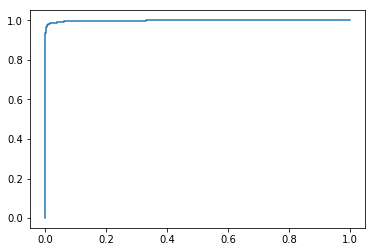

In [23]:
plt.plot(fpr,tpr);

In [24]:
auc(fpr,tpr)

0.9978481634583061

In [25]:
accuracy_score(y_test,y_pred), precision_score(y_test,y_pred), recall_score(y_test,y_pred)

(0.9835229501765398, 0.9952267303102625, 0.972027972027972)

In [26]:
top_features = list(sorted(zip(x_train.columns, gr.best_estimator_.feature_importances_), key=lambda x: x[1], reverse=True))
top_features

[('GTA', 0.09003652401418663),
 ('AC', 0.08263213018107105),
 ('AAC', 0.06958450467775397),
 ('GG', 0.06606977710733704),
 ('GA', 0.0589286889949739),
 ('ACC', 0.040623842679485905),
 ('AG', 0.038107280703247225),
 ('P49', 0.037367406674669396),
 ('P48', 0.032662350840522394),
 ('TA', 0.027445636028882586),
 ('TAA', 0.026271160998739603),
 ('TGT', 0.026077784462887908),
 ('TC', 0.02251505724437253),
 ('TGC', 0.021894471882359795),
 ('GCA', 0.020227116398951625),
 ('CAC', 0.019800726103241597),
 ('AA', 0.0186484417477189),
 ('TT', 0.015406860119575991),
 ('AGG', 0.012817232900039197),
 ('GAG', 0.012249330515451122),
 ('P46', 0.012143580954836695),
 ('TGG', 0.011154906199248584),
 ('CCC', 0.01097012552442134),
 ('AAA', 0.010537447667240102),
 ('GGA', 0.010107618547267319),
 ('GAT', 0.008731715068816155),
 ('CCT', 0.008655499864466037),
 ('TTT', 0.007450690099280189),
 ('CC', 0.007399913792329531),
 ('ATG', 0.007329509760446909),
 ('ACA', 0.00692941540889534),
 ('TCA', 0.00688831892376846

In [27]:
len(gr.best_estimator_.feature_importances_)

130

In [28]:
len(x_train.columns)

130

In [29]:
gr.best_estimator_.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 11,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 7,
 'verbose': 0,
 'warm_start': False}

In [30]:
pd.DataFrame(
    columns=pairs, data=[
        x_all[y_all==1][pairs].mean(),
        x_all[y_all==0][pairs].mean(),
        x_all[y_all==1][pairs].std(),
        x_all[y_all==0][pairs].std()
    ],
    index=['Mean t', 'Mean f', 'Std t', 'Std f']
).round(4)

,AA,AC,AG,AT,CA,CC,CG,CT,GA,GC,GG,GT,TA,TC,TG,TT
Mean t,7.0720,5.2589,1.5574,4.0702,4.4659,3.0958,0.4859,3.3482,0.7514,1.8147,0.1693,3.7446,5.4209,0.7964,4.2827,2.6657
Mean f,4.6798,2.4353,3.5301,3.7387,3.5473,2.5845,0.4546,3.4616,2.9287,2.0777,2.6057,2.4901,3.2465,2.9480,3.5056,4.7658
Std t,2.0862,1.2122,0.8200,1.5131,1.1364,1.1808,0.6288,0.8955,0.7018,0.7671,0.4445,1.2067,1.3856,1.0244,1.1750,1.4967
Std f,3.3750,1.6312,2.0264,2.3129,1.8820,2.5204,0.9290,2.0541,1.8884,1.6440,2.5532,1.6889,2.3104,1.9487,1.8899,3.4527


In [31]:
pd.DataFrame(
    columns=triplets, data=[
        x_all[y_all==1][triplets].mean(),
        x_all[y_all==0][triplets].mean(),
        x_all[y_all==1][triplets].std(),
        x_all[y_all==0][triplets].std()
    ],
    index=['Mean t', 'Mean f', 'Std t', 'Std f']
).round(1)

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
Mean t,2.9,2.4,0.9,0.8,2.0,1.7,0.4,1.3,0.5,0.1,...,0.0,0.3,0.2,1.6,0.1,2.4,1.0,0.3,0.7,0.4
Mean f,1.7,0.7,1.0,1.2,1.0,0.5,0.1,0.8,1.1,0.7,...,0.1,1.1,0.9,0.7,0.8,1.0,1.0,1.0,0.9,1.7
Std t,1.6,0.9,0.5,1.1,0.9,0.8,0.6,0.7,0.6,0.3,...,0.1,0.6,0.4,0.7,0.3,1.0,0.5,0.5,0.6,1.0
Std f,2.1,0.9,1.0,1.2,1.2,0.8,0.3,0.8,1.2,0.8,...,0.3,1.2,0.9,0.9,0.9,1.2,1.1,1.1,0.9,2.1


In [32]:
pd.DataFrame(
    columns=x_all.columns, data=[
        x_all[y_all==1].mean(),
        x_all[y_all==0].mean(),
        x_all[y_all==1].std(),
        x_all[y_all==0].std()
    ],
    index=['Mean t', 'Mean f', 'Std t', 'Std f']
).round(2)[list(filter(bool, map(lambda x: x[0] in pairs+triplets and x[0] or None, top_features)))[:20]]

,GTA,AC,AAC,GG,GA,ACC,AG,TA,TAA,TGT,TC,TGC,GCA,CAC,AA,TT,AGG,GAG,TGG,CCC
Mean t,1.96,5.26,2.42,0.17,0.75,1.66,1.56,5.42,2.61,2.37,0.80,1.63,1.64,1.63,7.07,2.67,0.07,0.03,0.08,1.00
Mean f,0.54,2.44,0.69,2.61,2.93,0.54,3.53,3.25,1.01,0.98,2.95,0.70,0.71,0.69,4.68,4.77,0.89,0.80,0.83,0.68
Std t,0.72,1.21,0.88,0.44,0.70,0.77,0.82,1.39,1.22,0.96,1.02,0.70,0.72,0.71,2.09,1.50,0.26,0.19,0.27,0.64
Std f,0.77,1.63,0.85,2.55,1.89,0.76,2.03,2.31,1.14,1.19,1.95,0.85,0.87,1.04,3.37,3.45,1.06,1.09,0.94,1.22
